# Mini Spark Broker: Connection to the stream

author: **Julien Peloton** [@JulienPeloton](https://github.com/JulienPeloton)  
Last Verifed to Run: 2019-02-04  

The purpose of this notebook is to connect the broker to the stream created by the LSST alert system.

**Useful Links:**

* https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
* https://databricks.com/blog/2017/02/23/working-complex-data-formats-structured-streaming-apache-spark-2-1.html
* https://databricks.com/blog/2016/07/28/structured-streaming-in-apache-spark.html
* https://docs.databricks.com/_static/notebooks/structured-streaming-python.html
* https://spark.apache.org/docs/2.2.0/structured-streaming-kafka-integration.html

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window
from pyspark.sql import Row

import io
import gzip
import time

import aplpy
import fastavro
import numpy as np
from astropy.io import fits

import matplotlib
import matplotlib.pyplot as plt

from lsst.msb import avroUtils

## Step 0: Running the LSST alert system

In order to play with this notebook, you need to create the stream of alerts. see the README file of the bootcamp to set up your environment and launch the stream.

## Step 1: Connecting to the stream with Apache Spark

Once the stream is produced, let's initialise the Spark context:

In [2]:
# Grab the running Spark Session, 
# otherwise create it.
spark = SparkSession \
    .builder \
    .appName("firstConnection") \
    .getOrCreate()

Let's initialise a DataFrame that will read the stream from Kafka. Note that `kafka.bootstrap.servers` and `subscribe` must correspond to the arguments used for the LSST alert system (see above). At this point, we just create a Kafka Source for Streaming Queries - nothing really happens:

In [3]:
# Create a DF from the incoming stream from Kafka
# Note that <kafka.bootstrap.servers> and <subscribe>
# must correspond to arguments of the LSST alert system.
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "my-stream") \
  .option("startingOffsets", "earliest") \
  .load()

df.isStreaming

True

As you can see, `df` is a streaming Dataframe. You can start streaming computation, by defining the sink and starting it. 
<!-- In our case, we want to interactively query the counts (same queries as above), so we will set the complete set of 1 hour counts to be in a in-memory table (note that this for testing purpose only in Spark 2.0). -->

## Step 2: First interaction with the stream

Let's see first if we can receive correctly alert packets. For this, we define a query to the stream that will just count every 5 seconds the number of alerts received by Spark:

In [4]:
# We group data by partitions, 
# and count the number of alerts per partition
# every 5 seconds.
streamingCountsDF = (
  df.groupBy(
      "partition", 
      window("timestamp", "5 seconds"))
    .count()
)

In [5]:
# keep the size of shuffles small
spark.conf.set("spark.sql.shuffle.partitions", "2")  

# Trigger the streaming computation, 
# by defining the sink (memory here) and starting it
countQuery = streamingCountsDF \
    .writeStream \
    .queryName("qcount")\
    .format("memory")\
    .outputMode("complete") \
    .start()

`qcount` is a handle to the streaming query that is running in the background. This query is continuously picking up alerts and updating the counts. Let's give a bit of time for the stream to update. 

In [6]:
time.sleep(10)

You can easily access information about the progress in real-time:

In [7]:
countQuery.recentProgress

[{'id': '312274f1-c667-4942-8f8d-693201196f8e',
  'runId': 'd693abe0-3c83-4aec-8f30-70af51b83bc0',
  'name': 'qcount',
  'timestamp': '2019-02-04T14:31:27.019Z',
  'batchId': 0,
  'numInputRows': 1497,
  'processedRowsPerSecond': 148.10051444400474,
  'durationMs': {'addBatch': 5805,
   'getBatch': 10,
   'getEndOffset': 0,
   'queryPlanning': 447,
   'setOffsetRange': 3680,
   'triggerExecution': 10107,
   'walCommit': 60},
  'stateOperators': [{'numRowsTotal': 297,
    'numRowsUpdated': 297,
    'memoryUsedBytes': 64269,
    'customMetrics': {'loadedMapCacheHitCount': 0,
     'loadedMapCacheMissCount': 0,
     'stateOnCurrentVersionSizeBytes': 63981}}],
  'sources': [{'description': 'KafkaV2[Subscribe[my-stream]]',
    'startOffset': None,
    'endOffset': {'my-stream': {'0': 1497}},
    'numInputRows': 1497,
    'processedRowsPerSecond': 148.10051444400474}],
  'sink': {'description': 'MemorySink'}},
 {'id': '312274f1-c667-4942-8f8d-693201196f8e',
  'runId': 'd693abe0-3c83-4aec-8f30

You can also use sql operations on the named in-memory query tables to create a classic DataFrame from the sink:

In [8]:
# Construct a DataFrame with time & number of alerts received by 
# window of 5 seconds
df_alert_count = spark.sql(
    """
    select 
        window.start as starting_utc_time, 
        window.end as ending_utc_time, 
        count as alerts_received 
    from 
        qcount 
    order by 
        ending_utc_time
    """
)

# Show the first rows of the DataFrame
df_alert_count.show()

# Count the number of alerts received so far
nalerts = df_alert_count.select("alerts_received").rdd.map(lambda x: x[0]).sum()
print("{} alerts received so far from the stream".format(nalerts))

+-------------------+-------------------+---------------+
|  starting_utc_time|    ending_utc_time|alerts_received|
+-------------------+-------------------+---------------+
|2019-02-04 10:02:35|2019-02-04 10:02:40|              1|
|2019-02-04 10:02:40|2019-02-04 10:02:45|              5|
|2019-02-04 10:02:45|2019-02-04 10:02:50|              5|
|2019-02-04 10:02:50|2019-02-04 10:02:55|              5|
|2019-02-04 10:02:55|2019-02-04 10:03:00|              5|
|2019-02-04 10:03:00|2019-02-04 10:03:05|              5|
|2019-02-04 10:03:05|2019-02-04 10:03:10|              5|
|2019-02-04 10:03:10|2019-02-04 10:03:15|              5|
|2019-02-04 10:03:15|2019-02-04 10:03:20|              5|
|2019-02-04 10:03:20|2019-02-04 10:03:25|              5|
|2019-02-04 10:03:25|2019-02-04 10:03:30|              5|
|2019-02-04 10:03:30|2019-02-04 10:03:35|              5|
|2019-02-04 10:03:35|2019-02-04 10:03:40|              5|
|2019-02-04 10:03:40|2019-02-04 10:03:45|              5|
|2019-02-04 10

Note the columns `starting_time` and `ending_time` here correspond to the UTC times at which the alert has been published in Kafka (not the time at which you grab the alert).

Below I plot the values collected after 3 full bursts of alerts sent at few hours interval:

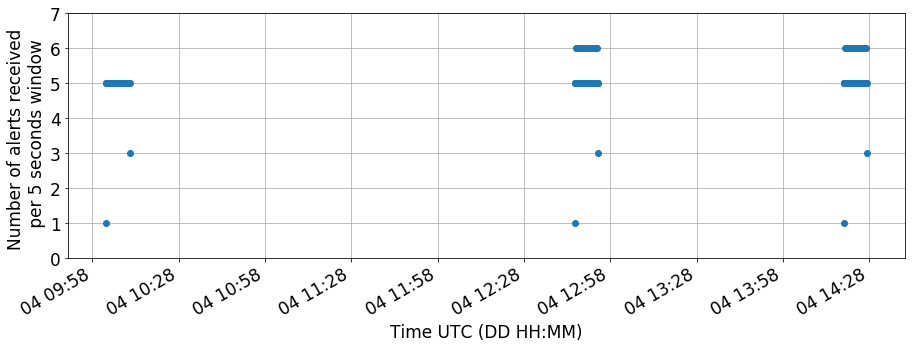

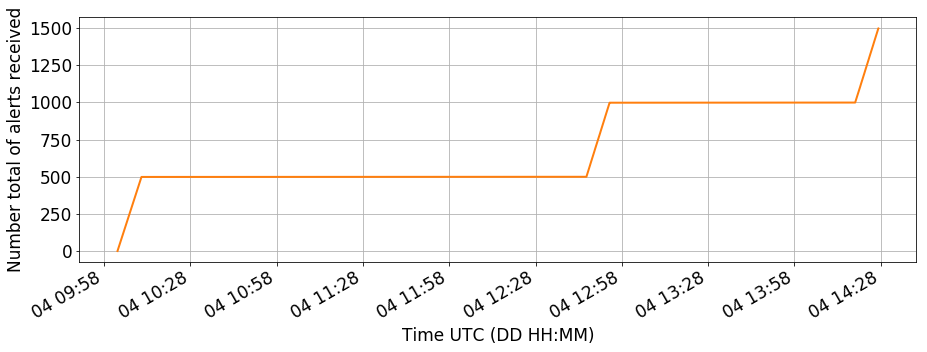

In [9]:
matplotlib.rcParams.update({'font.size': 17})

# Go to Pandas world for plotting
pandas_df = df_alert_count.toPandas()

fig = plt.figure(figsize=(15, 5))
plt.plot(
    pandas_df["ending_utc_time"], 
    pandas_df["alerts_received"], 
    ls="", marker="o", color="C0")
plt.grid()

plt.ylim(0, pandas_df["alerts_received"].max() + 1)
plt.xlabel("Time UTC (DD HH:MM)")
plt.ylabel("Number of alerts received \n per 5 seconds window")

plt.gcf().autofmt_xdate()

fig = plt.figure(figsize=(15, 5))
plt.plot(
    pandas_df["ending_utc_time"], 
    np.cumsum(pandas_df["alerts_received"]), 
    ls="-", lw=2, color="C1")
plt.grid()

plt.xlabel("Time UTC (DD HH:MM)")
plt.ylabel("Number total of alerts received")

plt.gcf().autofmt_xdate()

## Step 4: Digging the alerts

Now it is time to look at the alerts! The alert system encodes the alert in avro binary, so one needs to decode them.
The way to decode the alert is to know its schema. We put a template alert in the folder `schemas` for convenience. Let's create a sink with the whole stream from Kafka, and access the alert through a DataFrame:

In [10]:
rawQuery = df\
    .writeStream \
    .queryName("qraw")\
    .format("memory")\
    .start()

In [11]:
# Give a bit of time for synchronisation
time.sleep(10)

In [12]:
# DataFrame
df_raw = spark.sql("select * from qraw")
df_raw.show()

+----+--------------------+---------+---------+------+--------------------+-------------+
| key|               value|    topic|partition|offset|           timestamp|timestampType|
+----+--------------------+---------+---------+------+--------------------+-------------+
|null|[06 33 2E 32 32 5...|my-stream|        0|     0|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     1|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     2|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     3|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     4|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     5|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     6|2019-02-04 10:02:...|            0|
|null|[06 33 2E 32 32 5...|my-stream|        0|     7|2019-02-04 10:02:...|            0|
|null|[06 

We can look closely at the columns of this Dataframe:

In [13]:
df_raw.printSchema()
df_raw.describe().show()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)

+-------+---------+---------+-----------------+-------------+
|summary|    topic|partition|           offset|timestampType|
+-------+---------+---------+-----------------+-------------+
|  count|     1497|     1497|             1497|         1497|
|   mean|     null|      0.0|            748.0|          0.0|
| stddev|     null|      0.0|432.2909899593097|          0.0|
|    min|my-stream|        0|                0|            0|
|    max|my-stream|        0|             1496|            0|
+-------+---------+---------+-----------------+-------------+



The column of interest for us is `value` which contains the alert data. For the moment, the data is `binary`, so let's decode it. First read the corresponding schema (ZTF in this example):

In [14]:
# Read the schema
alert_schema = avroUtils.readSchemaFromAvroFile("../schemas/template_schema_ZTF.avro")

# Broadcast the schema to all Spark executors
# (Keep in mind we work in a distributed environment!)
sc.broadcast(alert_schema)

# Look at the available keys
print(alert_schema.keys())

dict_keys(['type', 'version', 'name', 'namespace', 'fields', 'doc'])


Now we have the schema, we can decode the alerts. For technical reason, you need to go to RDD world to use in a meaningful way the decoder:

In [15]:
# RDD: Resilient Distributed Dataset.
# Both Spark DataFrames and RDDs are distributed memory abstractions, fault-tolerant and immutable.
# The main difference is that Dataframes are organized into named columns with defined 
# data types and including the benefits of Spark SQL's execution engine.
# Historically, there were only RDDs. DataFrame came later in Spark.
rdd_alerts = df_raw.select("value").rdd.map(lambda x: avroUtils.decoder(x.value, alert_schema))

And here is one full alert:

In [16]:
rdd_alerts.take(1)

[{'schemavsn': '3.2',
  'publisher': 'ZTF (www.ztf.caltech.edu)',
  'objectId': 'ZTF18abyouwp',
  'candid': 697251920015010010,
  'candidate': {'jd': 2458451.7519213,
   'fid': 1,
   'pid': 697251920015,
   'diffmaglim': 19.647123336791992,
   'pdiffimfilename': 'ztf_20181129251771_000248_zg_c01_o_q1_scimrefdiffimg.fits',
   'programpi': 'Kulkarni',
   'programid': 1,
   'candid': 697251920015010010,
   'isdiffpos': 'f',
   'tblid': 10,
   'nid': 697,
   'rcid': 0,
   'field': 248,
   'xpos': 1817.9852294921875,
   'ypos': 2753.298828125,
   'ra': 26.8566983,
   'dec': -26.9677112,
   'magpsf': 14.283452987670898,
   'sigmapsf': 0.038736678659915924,
   'chipsf': 50.48195266723633,
   'magap': 14.340100288391113,
   'sigmagap': 0.008100000210106373,
   'distnr': 0.24791085720062256,
   'magnr': 12.048999786376953,
   'sigmagnr': 0.012000000104308128,
   'chinr': 0.6589999794960022,
   'sharpnr': 0.032999999821186066,
   'sky': 0.5009307861328125,
   'magdiff': 0.05664699897170067,
   '

One could convert this RDD back to DataFrame, but the schema of the alerts is nested, which can lead to trouble.
Instead, let's see what are the keys we have in the alert:

In [17]:
rdd_alerts.map(lambda x: [ (i, type(j)) for i, j in zip(x.keys(), x.values())]).take(1)

[[('schemavsn', str),
  ('publisher', str),
  ('objectId', str),
  ('candid', int),
  ('candidate', dict),
  ('prv_candidates', list),
  ('cutoutScience', dict),
  ('cutoutTemplate', dict),
  ('cutoutDifference', dict)]]

### Candidate

The entry candidate is a simple `dict` that can be transformed into a standalone DataFrame:

In [18]:
# Go from RDD to Dataframe
df_alerts = rdd_alerts.map(lambda x: Row(**x["candidate"])).toDF()

# Look at the schema
df_alerts.printSchema()

root
 |-- aimage: double (nullable = true)
 |-- aimagerat: double (nullable = true)
 |-- bimage: double (nullable = true)
 |-- bimagerat: double (nullable = true)
 |-- candid: long (nullable = true)
 |-- chinr: double (nullable = true)
 |-- chipsf: double (nullable = true)
 |-- classtar: double (nullable = true)
 |-- clrcoeff: double (nullable = true)
 |-- clrcounc: double (nullable = true)
 |-- clrmed: double (nullable = true)
 |-- clrrms: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- decnr: double (nullable = true)
 |-- diffmaglim: double (nullable = true)
 |-- distnr: double (nullable = true)
 |-- distpsnr1: double (nullable = true)
 |-- distpsnr2: double (nullable = true)
 |-- distpsnr3: double (nullable = true)
 |-- dsdiff: double (nullable = true)
 |-- dsnrms: double (nullable = true)
 |-- elong: double (nullable = true)
 |-- exptime: double (nullable = true)
 |-- fid: long (nullable = true)
 |-- field: long (nullable = true)
 |-- fwhm: double (nullable = true)

You can easily select all the values for a subset of columns, e.g. 

In [19]:
colnames = ["ra", "dec", "fwhm", "candid","nbad"]
df_alerts.select(colnames).show()

+----------+-----------+------------------+------------------+----+
|        ra|        dec|              fwhm|            candid|nbad|
+----------+-----------+------------------+------------------+----+
|26.8566983|-26.9677112|2.3299999237060547|697251920015010010|   0|
|  26.24497|-26.7569436|1.5973387956619263|697251920115015007|   0|
|26.1126147|-26.8053928|1.5973387956619263|697251920115015008|   0|
|25.5844032|-27.9239037|1.5603374242782593|697251920215010008|   0|
|25.5902591|-27.9131274|1.5603374242782593|697251920215010010|   0|
|26.0145383|-27.9003972|1.5603374242782593|697251920215010011|   0|
|25.6648433|-27.8417869|1.5603374242782593|697251920215010013|   0|
|24.4538066|-27.0766656|1.7182927131652832|697251920415010000|   0|
|24.9350326|-26.5438418|3.7100000381469727|697251920415015001|   0|
| 23.517342|-27.0446981| 1.781453013420105|697251920515010004|   0|
| 23.439535|-26.9757725| 1.781453013420105|697251920515010007|   0|
|23.5013762|-26.9553962| 1.781453013420105|69725

### Cutout

The `cutout*` entries contain square images around the position of the alert. Let's have a look at a few of those:

In [20]:
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    """ Plot square FITS image stores in the ZTF alert.
    Borrowed from the ZTF repo: 
    https://github.com/ZwickyTransientFacility/ztf-avro-alert/
    
    Parameters
    ----------
    stamp: bytes
        Binary image data
        
    Returns
    ----------
    ffig: FITSFigure
    """
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            if fig is None:
                fig = plt.figure(figsize=(4,4))
            if subplot is None:
                subplot = (1,1,1)
            ffig = aplpy.FITSFigure(
                hdul[0], figure=fig, subplot=subplot, **kwargs)
            ffig.show_grayscale(stretch='arcsinh')
    return ffig

INFO: Auto-setting vmin to  4.893e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.019e+03 [aplpy.core]


INFO: Auto-setting vmin to  6.044e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.376e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.458e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.382e+02 [aplpy.core]


INFO: Auto-setting vmin to  5.310e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.278e+03 [aplpy.core]


INFO: Auto-setting vmin to  6.599e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.974e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.783e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.903e+01 [aplpy.core]


INFO: Auto-setting vmin to  5.392e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.730e+03 [aplpy.core]


INFO: Auto-setting vmin to  6.602e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.188e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.768e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.262e+01 [aplpy.core]


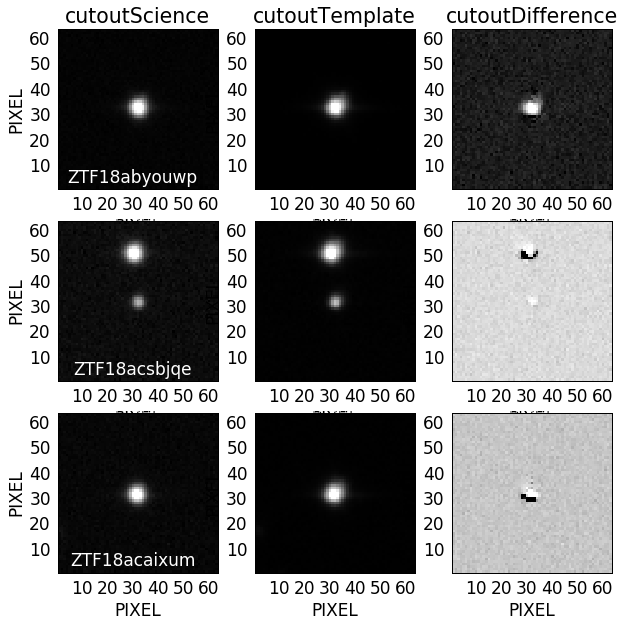

In [21]:
# Take a few alerts
alerts = rdd_alerts.take(3)

fig = plt.figure(figsize=(10, 10))
for index_alert, alert in enumerate(alerts):
    for index_cutout, cutout in enumerate(
            ["cutoutScience", "cutoutTemplate", "cutoutDifference"]):
        o = plot_cutout(
            alert[cutout]["stampData"], 
            fig=fig, subplot=(3, 3, 3*index_alert+index_cutout+1))
        if index_alert == 0:
            o.set_title(cutout)
        if index_cutout == 0:
            o.add_label(30, 5, "{}".format(alert["objectId"]), color="white")

### Alternative to quickly create DataFrames

You can also select a few entries of interest from the full alert, and make a DataFrame out of those:

In [22]:
def myEntries(dic):
    """ Returns only tuple of values from a dictionary
    
    Parameters
    ----------
    dic: dict
        Python dictionary (the alert)
        
    Returns
    ----------
    out: tuple of values
    """
    ID = dic["objectId"]
    ra = dic["candidate"]["ra"]
    dec = dic["candidate"]["dec"]
    imdiff = dic["prv_candidates"][0]["pdiffimfilename"]
    
    return (ID, ra, dec, imdiff)

mydf = rdd_alerts.map(myEntries).toDF(["ID", "RA", "DEC", "pdiffimfilename"])
mydf.show()

+------------+----------+-----------+--------------------+
|          ID|        RA|        DEC|     pdiffimfilename|
+------------+----------+-----------+--------------------+
|ZTF18abyouwp|26.8566983|-26.9677112|/ztf/archive/sci/...|
|ZTF18acsbjqe|  26.24497|-26.7569436|/ztf/archive/sci/...|
|ZTF18acaixum|26.1126147|-26.8053928|/ztf/archive/sci/...|
|ZTF18acsbjqg|25.5844032|-27.9239037|/ztf/archive/sci/...|
|ZTF18acsbjqi|25.5902591|-27.9131274|/ztf/archive/sci/...|
|ZTF18acsbjqf|26.0145383|-27.9003972|/ztf/archive/sci/...|
|ZTF18acsbjqh|25.6648433|-27.8417869|/ztf/archive/sci/...|
|ZTF18acsbjou|24.4538066|-27.0766656|/ztf/archive/sci/...|
|ZTF18abvdmcb|24.9350326|-26.5438418|/ztf/archive/sci/...|
|ZTF18acsbjpf| 23.517342|-27.0446981|/ztf/archive/sci/...|
|ZTF18acsbjpe| 23.439535|-26.9757725|/ztf/archive/sci/...|
|ZTF18acsbjpg|23.5013762|-26.9553962|/ztf/archive/sci/...|
|ZTF18acsbjph|23.4996432|-26.8807163|/ztf/archive/sci/...|
|ZTF18abvrcws|23.9507731|-26.8155047|/ztf/archive/sci/..